# Delay embeddings for simple pendulum

In [ ]:
import numpy as np
from numpy import random
from importlib import reload
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

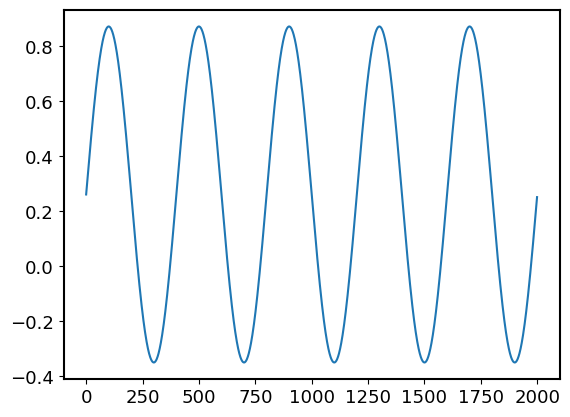

[0, 1]


(<matplotlib.legend.Legend at 0x1eb9d579ee0>,
 <matplotlib.legend.Legend at 0x1eb9d582fa0>)

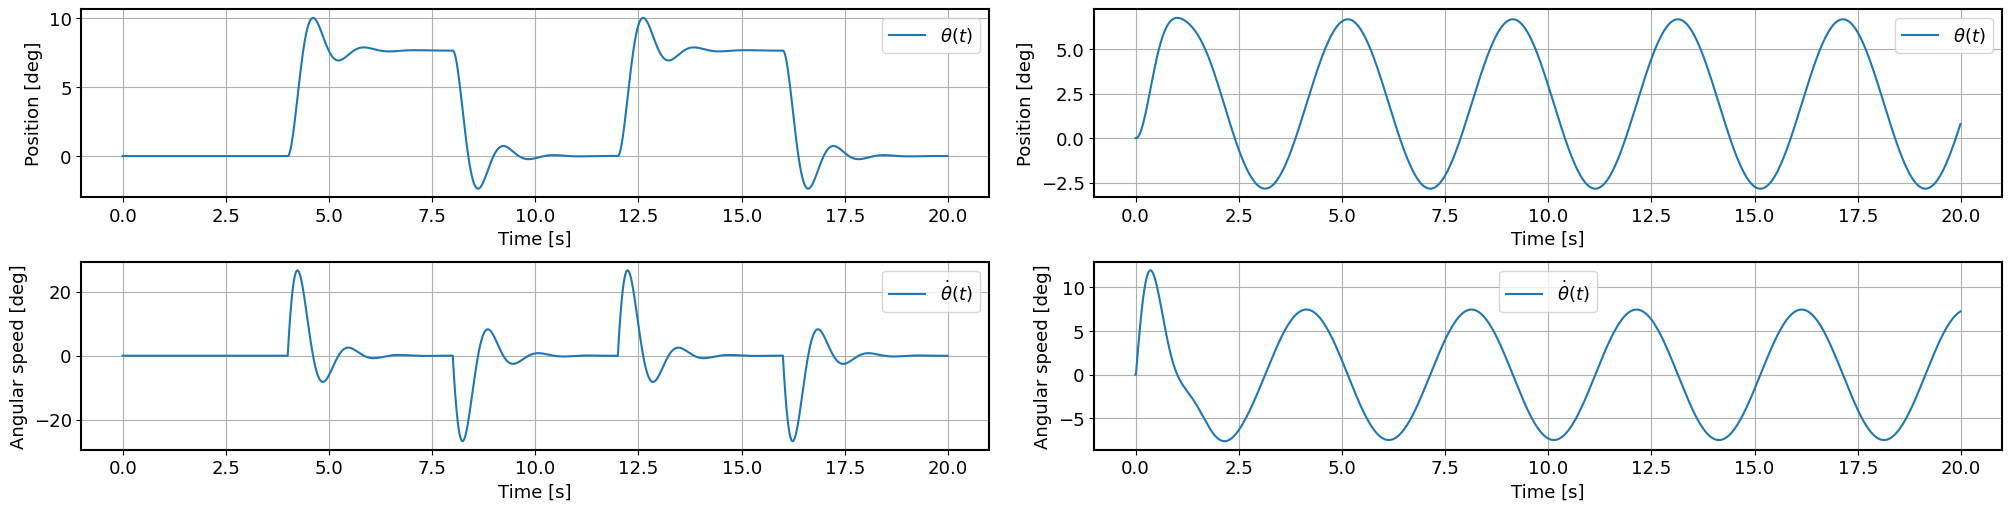

In [8]:
pend1, pend2 = SimplePendulum(mass=.8, length=.8), SimplePendulum(mass=.8, length=.8) # Create pendulum instance
pend1.dt, pend2.dt = 1e-2, 1e-2
pend1.T, pend1.X0, pend2.T, pend2.X0 = np.arange(0,20,pend1.dt), np.array([deg2rad(0),0]), np.arange(0,20,pend2.dt), np.array([deg2rad(0),0])
pend1.N, pend2.N = len(pend1.T), len(pend2.T)
K, Td, Ti = 1, 1e-2, 1e-1 # P(I)D controller parameters
f_ref = 0.25 # Reference frequency

# Reference and associated precision ratio (for LQR)
pend1.T_ref, pend2.T_ref = np.int(1/f_ref/pend1.dt), np.int(1/f_ref/pend2.dt)
pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(60),0], np.int(T_ref/20), 0)
pend2.ref = sineReference(pend2.N, pend2.T_ref, [-deg2rad(20), deg2rad(50)])
plt.plot(pend2.ref), plt.show()
print([i for i in range(2)])

pend1.U, pend2.U = np.zeros(shape=[pend1.N-1]), np.zeros(shape=[pend2.N-1])
pend1.X, pend2.X = np.empty(shape=[2,pend1.N]), np.empty(shape=[2,pend2.N])
pend1.X[:,0], pend2.X[:,0] = pend1.X0, pend2.X0
for i in range(pend1.N-1):
    if i == 0:
        pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X0, 0, pend1.dt, type='controller-step-by-step')
        pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X0, 0, pend2.dt, type='controller-step-by-step')
    else:
        pend1.U[i], pend2.U[i] = PD(pend1.X, i, pend1.ref[i], K, Td, pend1.dt)[1], PD(pend2.X, i, pend2.ref[i], K, Td, pend2.dt)[1]
        pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
        pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')

# Plots
fig, ax = plt.subplots(2, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

## Delay embeddings
The base regression problem writes under the form : <br><br>
$$\begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k) \Longrightarrow \begin{pmatrix} x_1(1) & x_2(1) \\ \vdots & \vdots \\ x_1(T) & x_2(T) \end{pmatrix} = \begin{pmatrix} x_1(0) & x_2(0) & u(0) \\ \vdots & \vdots & \vdots \\ x_1(T-1) & x_2(T-1) & u(T-1) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix} $$ <br><br>

However, this assumes that every single observation only linearly depends on the preceding one. This assumptions can be removed by setting a delay $\tau$ and now assuming that each state can be linearly expressed as a combination of the $\tau$ preceding states. In a Koopman framework, this can be thought as a state extension since the matrices $A$ and $B$ will both be extended too. Considering only one measurement at a time, this yields : <br><br>

$$ \begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} & A_{13} & \cdots & A_{(1,\tau/2-2)} & A_{(1,\tau/2-1)} \\ A_{21} & A_{22} & A_{23} & \cdots & A_{(2,\tau/2-1)} & A_{(2,\tau/2-1)} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \\ x_1(k-1) \\ x_2(k-1) \\ \vdots \\ x_1(k-\tau) \\ x_2(k-\tau) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k) $$<br><br>

This assumption was however not proposed for the input, for now (let's consider things separately at first). Of course, all of this will be set up by taking the whole simulation horizon into account for a more accurate result.<br><br>

$$ \begin{pmatrix} x_1(k+1) & x_2(k+1) \\ \vdots & \vdots \\ x_1(k+T) & x_2(k+T) \end{pmatrix} = \begin{pmatrix} x_1(k) & x_2(k) & x_1(k-1) & x_2(k-1) & \cdots & x_1(k-\tau) & x_2(k-\tau) & u(k) & \cdots & u(k-\tau) \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\ x_1(k+T-1) & x_2(k+T-1) & x_1(k+T-2) & x_2(k+T-2) & \cdots & x_1(k+T-1-\tau) & x_2(k+T-1-\tau) & u(T-1) & \cdots & u(T-1-\tau) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix} $$

In [172]:
horizon = np.int(len(pend1.T)/2) # Trajectory planning horizon
tau = 10 # Maximum delay allowed

DLS1 = DelayedLeastSquare(pend1.X, tau, horizon, pend1.U[:], nb_u=1)
DLS1.solve()
print(DLS1.A.shape[1])
print('A is : \n',DLS1.A,'\n\n\n\nB is : \n',DLS1.B)

20
A is : 
 [[ 8.82628e+02 -4.39519e-01  2.96521e+02 -1.03011e+00 -1.45951e+02
  -1.10525e+00 -4.42477e+02 -8.10961e-01 -5.91267e+02 -2.94088e-01
  -5.91317e+02  2.97205e-01 -4.42558e+02  8.14144e-01 -1.45864e+02
   1.10836e+00  2.97107e+02  1.03273e+00  8.84179e+02  4.42093e-01]
 [ 1.76346e+06 -8.80140e+02  5.92041e+05 -2.05993e+03 -2.92271e+05
  -2.20952e+03 -8.84855e+05 -1.62081e+03 -1.18214e+06 -5.87309e+02
  -1.18210e+06  5.94811e+02 -8.84618e+05  1.62817e+03 -2.91430e+05
   2.21620e+03  5.94147e+05  2.06484e+03  1.76776e+06  8.83888e+02]] 



B is : 
 [[4.67068e-07]
 [9.34135e-04]]


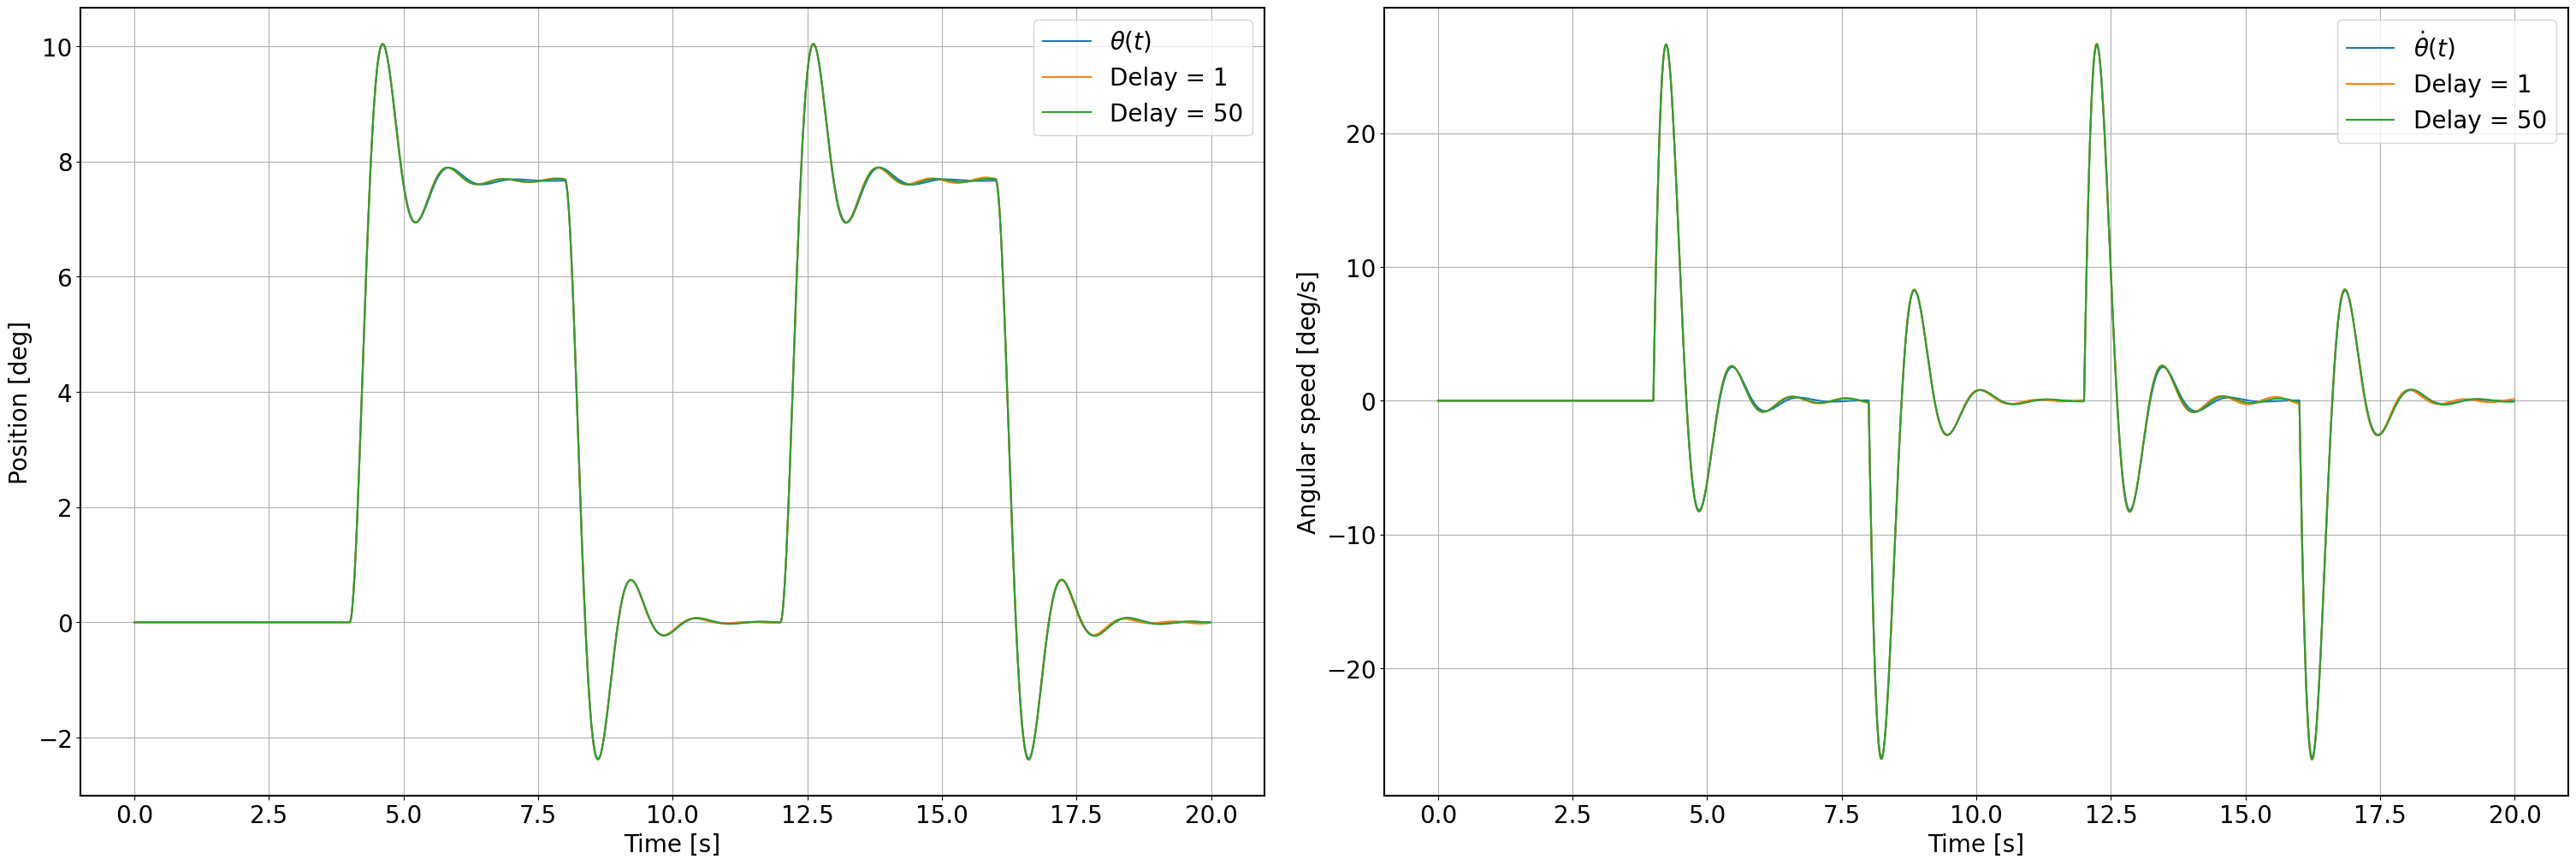

In [244]:
# Several plots
nb_delay = [1, 50]
nb_plots = len(nb_delay)
horizon = np.int(pend1.N/2)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(30,10))
ax[0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()
for i in range(nb_plots):
    tau = nb_delay[i]
    DLS1 = DelayedLeastSquare(pend1.X, tau, horizon, pend1.U[:], nb_u=1)
    DLS1.solve()
    DLS1.computeTrajectory(pend1.X0, pend1.U)
    
    ax[0].plot(pend1.T[:len(pend1.T)-1], rad2deg(DLS1.Traj[0,:]), label='Delay = '+str(tau))
    ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(pend1.T[:len(pend1.T)-1], rad2deg(DLS1.Traj[1,:]), label='Delay = '+str(tau))
    ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
    ax[1].grid()
    ax[1].legend()

# LQR simulation with embedded delays

In [279]:
A_LQR = np.zeros(shape=[2*tau,2*tau])
A_LQR[0:2,:], A_LQR[2:2*tau,0:2*tau-2] = DLS1.A, np.eye(2*tau-2)
B_LQR = np.zeros(shape=[2*tau])
B_LQR[0:2] = DLS1.B[0]
B_LQR = B_LQR[:,np.newaxis]
lqr_tracking = pbd.LQR(A_LQR, B_LQR, nb_dim=A_LQR.shape[0], dt=pend1.dt, horizon=pend1.N)

# Trajectory for tracking
tracking_traj = np.zeros(shape=[pend1.N,2*tau]) # Vector for storing the trajectory
tracking_traj[:,0] = ref
lqr_tracking.z = tracking_traj

# Trajectory timing (1 via-point = 1 time-step, should be as long as the horizon)
seq_tracking = 1*[0]

for i in range(1,pend1.N):
    seq_tracking += (1)*[i]
    
lqr_tracking.seq_xi = seq_tracking

# Control precision 
u_std = 15. # means 1e-3
lqr_tracking.gmm_u = u_std

# Tracking precision
x_std = 1e6 # Importance of tracking the position
Q_tracking = np.zeros(shape=[pend1.N,2*tau,2*tau])

for i in range(pend1.N):
    Q_tracking[i,0:2,0:2] = np.diag([x_std*precision[i],0*x_std]) # Put zero velocity precision
    
lqr_tracking.Q = Q_tracking
print(Q_tracking.shape)

lqr_tracking.ricatti()

(2000, 100, 100)


[ 0.00000e+00  2.12335e-11  1.12771e-08 ... -9.49018e-03 -9.31666e-03
 -9.11236e-03]


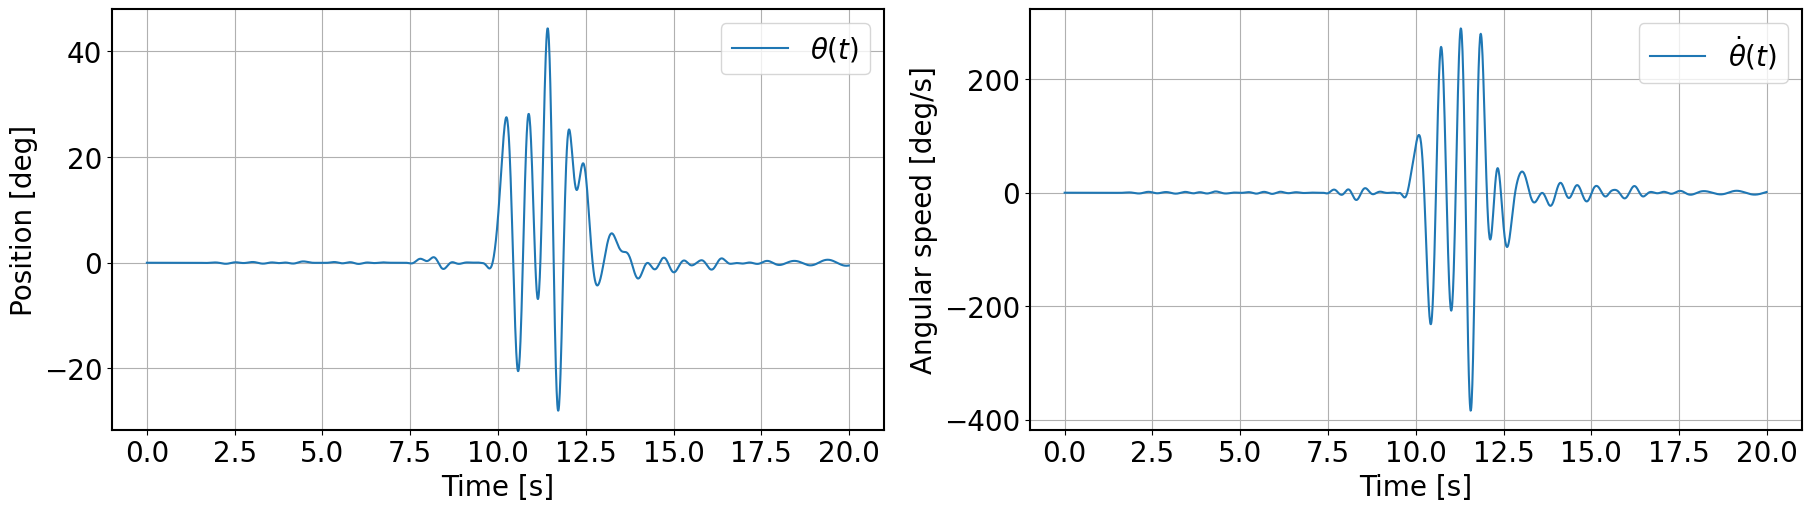

In [280]:
# Simulate the closed-loop system
X0 = np.zeros((10,2*tau))
xs, us = lqr_tracking.make_rollout(X0)

# Plot
fig,ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(18,5))
xs_mean = np.mean(xs, axis=0)
xs_std  = np.std(xs, axis=0)

ax[0].plot(pend1.T, rad2deg(xs_mean[:,0]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend1.T, rad2deg(xs_mean[:,1]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()
print(xs_mean[:,0])

(1,)
[ 0.00000e+00 -1.01036e-10 -5.36520e-08 ... -2.04545e-07  1.42760e-06
  3.62129e-06]


C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  output[0:2] = np.array([dx1dt,dx2dt])
C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:30: RuntimeWarning: overflow encountered in add
  X = X0 + dt / 6. * (k1 + 2. * k2 + 2. * k3 + k4)
C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:157: RuntimeWarning: invalid value encountered in sin
  dx2dt = 2/(self.m*self.l*

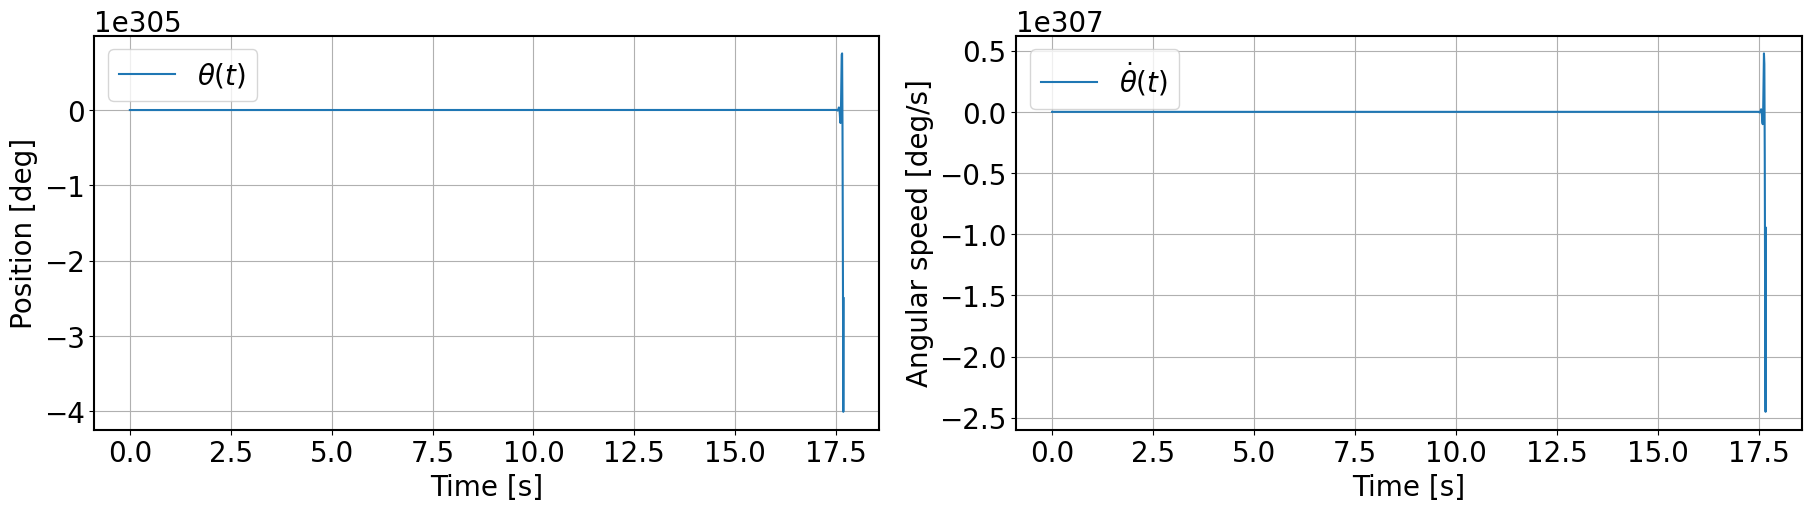

In [264]:
X0 = np.zeros(shape=[2*tau]) # Initial condition : [position [rad], velocity [rad/s]]
t_interval = pend1.dt # Time-interval for one step to occur
Xc = np.empty(shape=[pend1.N,2*tau]) # Controlled trajectory
Uc = np.empty(shape=[pend1.N-1]) # Control input history
Xc[0,:] = X0
print(lqr_tracking.get_command(Xc[0,:], 0).shape)
f = lambda theta, u : pend1.dynamicsDelayed(theta, u, tau)
# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend1.N-1):
    
    u = lqr_tracking.get_command(Xc[i,:], i) # Retrieve LQR control input
    Uc[i] = u
    # Next point of the non-linear controlled trajectory
    Xc[i+1,:] = RK4(f, Xc[i,:], [u], t_interval, type='controller-step-by-step').T
    
# Plot
fig,ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(18,5))

ax[0].plot(pend1.T, rad2deg(Xc[:,0]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend1.T, rad2deg(Xc[:,1]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()
print(xs_mean[:,0])